In [1]:
import torch
import pandas as pd
import shap
import matplotlib.pyplot as plt

# ==================================
# 1. Load trained NeuralPolicy
# ==================================
from udrl.policies import SklearnPolicy, NeuralPolicy # <-- adjust import path

policy = NeuralPolicy.load(r"data/Acrobot-v1/estimator_nameneural_max_episode5/42/policy")
model = policy.estimator
model.eval()

# ==================================
# 2. Load dataset
# ==================================
data = pd.read_csv(r"data\Acrobot-v1\estimator_nameneural_max_episode5\42\training_data.csv")

e:\liege\upside_down_rl\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\liege\upside_down_rl\udrl\policies.py:355: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weigh

In [2]:
model.eval()

BehaviorNet(
  (state_entry): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (command_entry): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (model): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
    (7): Softmax(dim=-1)
  )
)

In [3]:
import numpy as np
# Split into state, command, target
state_cols = [c for c in data.columns if c.startswith("state_")]
command_cols = ["desired_return", "desired_horizon"]

X_state = data[state_cols].values.astype("float32")
X_command = data[command_cols].values.astype("float32")
y = data.iloc[:, -1].values  # target

In [4]:
# First row from X_state (already numpy), wrap into torch tensor
state = torch.tensor(X_state[100], dtype=torch.float32).unsqueeze(0)   # (1, 6)

# First row from X_command (already numpy), wrap into torch tensor
command = torch.tensor(X_command[100], dtype=torch.float32).unsqueeze(0)  # (1, 2)

# Run through model
model.eval()
with torch.no_grad():
    probs = model(state, command)              # (1, 3)
    pred_class = torch.argmax(probs, dim=1).item()
    print("Probabilities:", probs.numpy())
    print("Predicted class:", pred_class)


Probabilities: [[0.27945086 0.4493097  0.2712394 ]]
Predicted class: 1


In [5]:
# Take first 5 rows
state_batch = torch.tensor(X_state[:5], dtype=torch.float32)     # (5, 6)
command_batch = torch.tensor(X_command[:5], dtype=torch.float32) # (5, 2)

# Forward pass
model.eval()
with torch.no_grad():
    probs = model(state_batch, command_batch)   # (5, 3) probabilities
    pred_classes = torch.argmax(probs, dim=1)   # (5,) predicted class indices

print("Probabilities:\n", probs.numpy())
print("Predicted classes:", pred_classes.numpy())


Probabilities:
 [[0.277044   0.4536236  0.2693324 ]
 [0.27793518 0.4519016  0.27016324]
 [0.27684158 0.4540178  0.26914063]
 [0.27573436 0.45616382 0.26810187]
 [0.2758176  0.45600986 0.2681726 ]]
Predicted classes: [1 1 1 1 1]


In [6]:
np.unique(pred_classes.numpy())

array([1], dtype=int64)

In [7]:
import numpy as np
import torch

# Assuming data is loaded
X_state = data[state_cols].values.astype("float32")
print(X_state)
X_command = data[command_cols].values.astype("float32")

# Create a single full input sample
sample_idx = 0
single_x_full = np.hstack([X_state[sample_idx:sample_idx+1], X_command[sample_idx:sample_idx+1]])

# Split the single sample for the model
n_state = X_state.shape[1]
state_tensor = torch.tensor(single_x_full[:, :n_state], dtype=torch.float32)
command_tensor = torch.tensor(single_x_full[:, n_state:], dtype=torch.float32)

[[ 9.9982208e-01 -1.8864397e-02  9.9898672e-01 -4.5005571e-02
  -5.2629568e-02  5.3895596e-02]
 [ 9.9917251e-01 -4.0673710e-02  9.9999750e-01  2.2296919e-03
  -1.5951158e-01  4.0677184e-01]
 [ 9.9862188e-01 -5.2481767e-02  9.9914056e-01  4.1450784e-02
   4.4598714e-02 -2.2434374e-02]
 ...
 [ 9.9977100e-01 -2.1399235e-02  1.4607136e-01 -9.8927408e-01
  -2.2955306e+00  3.3585310e+00]
 [ 8.9397931e-01 -4.4810826e-01  7.8153121e-01 -6.2386614e-01
  -2.0669479e+00  4.0091734e+00]
 [ 6.8928927e-01 -7.2448623e-01  9.9535114e-01  9.6312590e-02
  -1.2903897e+00  3.4779153e+00]]


In [10]:
import shap
import torch
import numpy as np

# Select a subset of data for SHAP (100 samples)
X_state_sample = X_state[:100]
X_command_sample = X_command[:100]

# Define a prediction function that SHAP can call
def predict_fn(inputs):
    """
    SHAP will pass a 2D numpy array. We'll split it back into state & command.
    """
    # inputs shape: (batch_size, 8) because 6 state + 2 command
    state = torch.tensor(inputs[:, :6], dtype=torch.float32)  #For CartPole change to :4] for Acrobot use :6]
    command = torch.tensor(inputs[:, 6:], dtype=torch.float32)  #For CartPole change to :4] for Acrobot use :6]
    
    model.eval()
    with torch.no_grad():
        probs = model(state, command).numpy()
    return probs

# Combine state + command into one array for SHAP
X_combined = np.hstack([X_state_sample, X_command_sample])  # shape (100, 8)


In [11]:
X_combined.shape # Should be (num_samples, num_features)

(100, 8)

In [12]:
# Use a smaller background set for speed (e.g., 20 random samples)
background = X_combined[np.random.choice(X_combined.shape[0], 20, replace=False)]

# Initialize SHAP explainer
explainer = shap.KernelExplainer(predict_fn, background)

# Compute SHAP values for the 100 samples
shap_values = explainer.shap_values(X_combined)


100%|██████████| 100/100 [00:01<00:00, 63.42it/s]


In [13]:
print(len(shap_values))  # 3
shap_values[0].shape  # (100, 8)
shap_values[1].shape  # (100, 8)
shap_values[2].shape  # (100, 8)


100


(8, 3)

In [14]:
shap_values.shape  # Should be (num_classes, num_samples, num_features)

(100, 8, 3)

In [15]:
# Rearrange axes
shap_values = np.transpose(shap_values, (2, 0, 1))  # now (3, 100, 8)


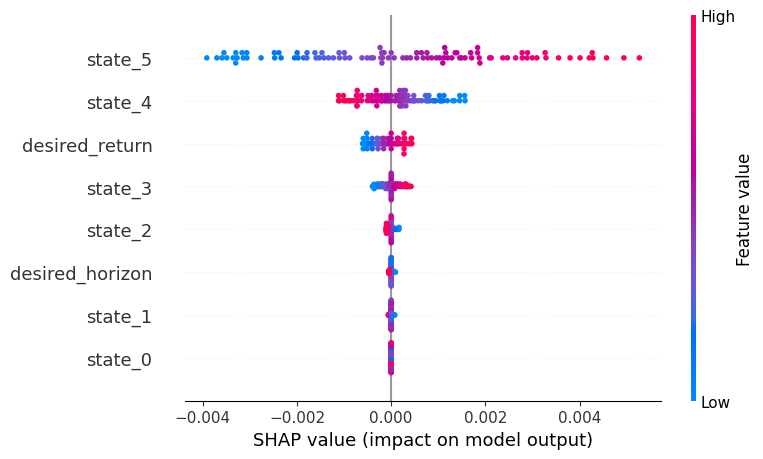

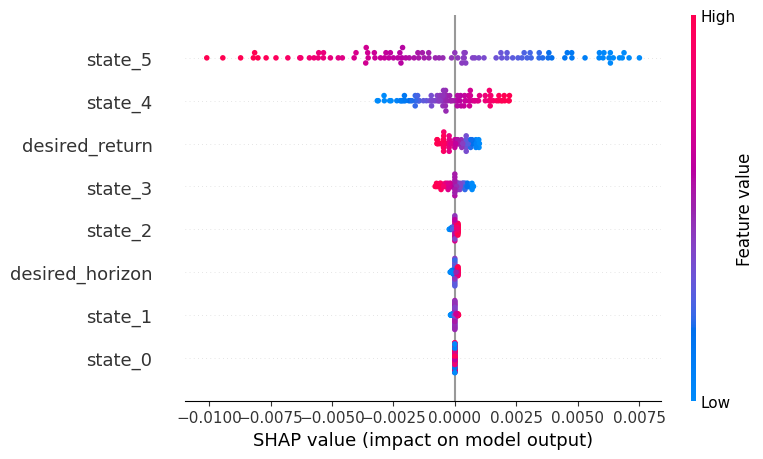

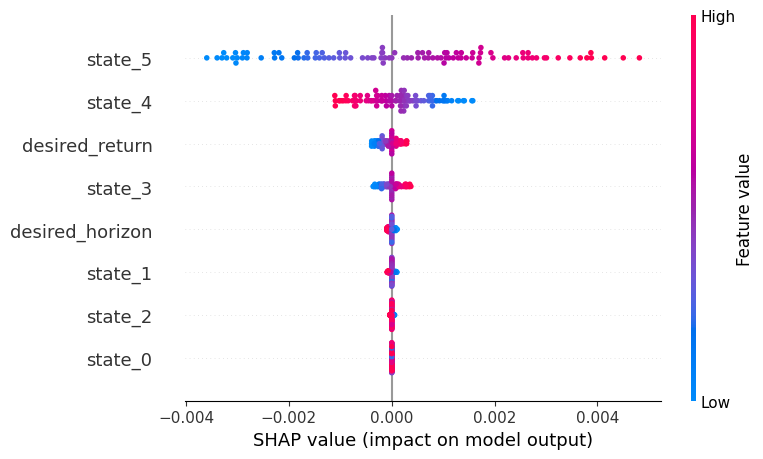

In [16]:
# Summary plot for class 0
shap.summary_plot(shap_values[0], X_combined, feature_names=state_cols + command_cols)

# Summary plot for class 1
shap.summary_plot(shap_values[1], X_combined, feature_names=state_cols + command_cols)

# Summary plot for class 2
shap.summary_plot(shap_values[2], X_combined, feature_names=state_cols + command_cols)


In [184]:
# Local explanation (e.g., first sample)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_combined[0], feature_names=state_cols + command_cols)

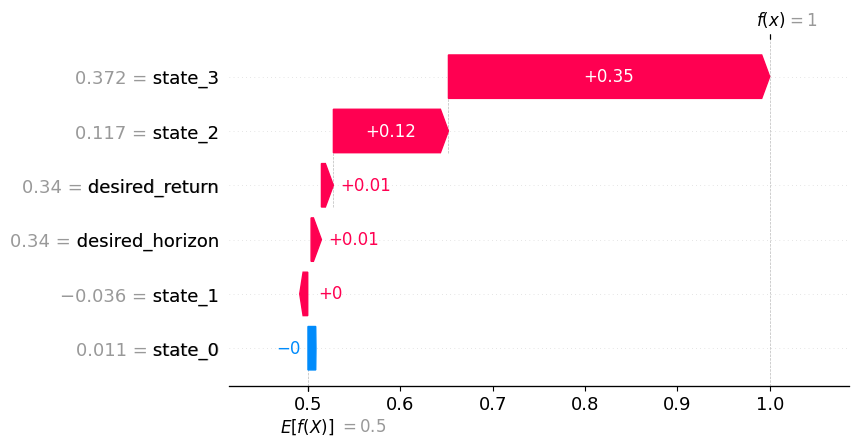

In [186]:
# Pick a sample and class
i = 20 # first sample
class_id = 1

# Build SHAP Explanation object
expl = shap.Explanation(
    values=shap_values[class_id][i],
    base_values=explainer.expected_value[class_id],
    data=X_combined[i],
    feature_names=state_cols + command_cols
)

# Waterfall plot
shap.plots.waterfall(expl)


In [17]:
# Local explanation for sample 0, class 0
sample_idx = 12
class_idx = 1

shap.force_plot(
    explainer.expected_value[class_idx],
    shap_values[class_idx][sample_idx],
    X_combined[sample_idx],
    feature_names=state_cols + command_cols
)


In [154]:
# LIME analysis for your PyTorch classifier
# Requirements: pip install lime matplotlib numpy

import numpy as np
import torch
from lime import lime_tabular
import matplotlib.pyplot as plt

# --- 1) Make sure you have a predict function that returns probabilities as numpy ---
# If you already defined predict_fn for SHAP, reuse it (it must return np.array of probs)
# Example (repeat or ensure you have the same):
def predict_fn(inputs):
    """
    inputs: numpy array (n_samples, 8)
    returns: numpy array (n_samples, n_classes) of probabilities
    """
    state = torch.tensor(inputs[:, :4], dtype=torch.float32)  #For CartPole change to :4] for Acrobot use :6]
    command = torch.tensor(inputs[:, 4:], dtype=torch.float32)  #For CartPole change to :4] for Acrobot use :6]

    model.eval()
    with torch.no_grad():
        logits = model(state, command)
        probs = torch.softmax(logits, dim=1)  # ensure probabilities
    return probs.cpu().numpy()


In [173]:

# --- 2) Prepare data and metadata for LIME ---
# X_combined is (n_samples, 8) as you already have
X = X_combined  # numpy array
feature_names = state_cols + command_cols  # list of 8 names
class_names = [str(i) for i in range(probs.shape[1])]  # or ['left','right','up'] etc if you have labels

# If your features are continuous, LIME will discretize by default.
# If you have categorical features, provide their indices in categorical_features list.
categorical_features = []  # e.g., [6, 7] if command columns are categorical (they're probably continuous)

# Create a LimeTabularExplainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X,                # training set or representative data (numpy)
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True     # often helpful; turn off if you don't want discretization
)



Predicted class: 1  probs: [0.26894143 0.7310586 ]
LIME explanation (feature, weight) for class 1
[('state_3 > 0.36', 0.2494798774885738), ('state_2 > 0.05', 0.0897606400195117), ('0.42 < desired_return <= 0.67', 0.024039418444222183), ('0.42 < desired_horizon <= 0.67', 0.009738559200988147)]


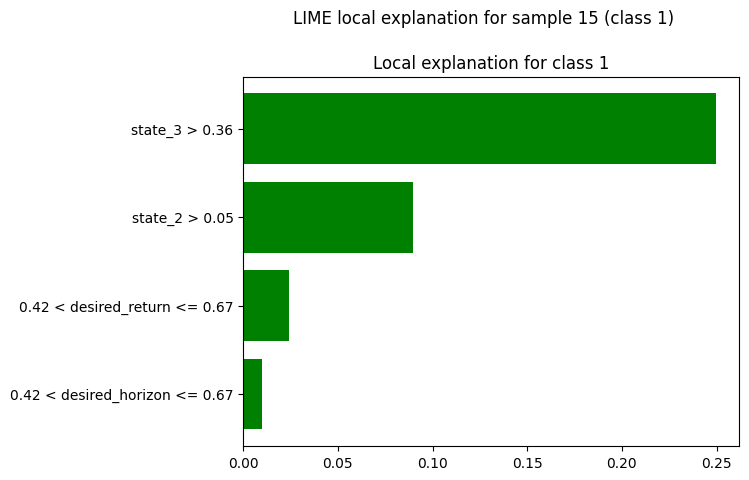

In [175]:
# --- 3) Explain a single instance (waterfall-style equivalent in LIME) ---
sample_idx = 15 # index to explain
sample = X[sample_idx]

# LIME's explain_instance expects a function that maps 2D -> 2D probs; our predict_fn fits that when wrapped
exp = explainer.explain_instance(
    data_row=sample,
    predict_fn=predict_fn,
    num_features=4, #change accordingly btw acrobat and cartpole          # how many features to show in explanation 
    top_labels=2,   #change accordingly btw acrobat and cartpole          # compute explanations for top 3 predicted classes (or set to 1)
    num_samples=5000         # number of perturbation samples used to fit local surrogate (increase for stability)
)

# Show the explanation for the predicted class (or any class)
pred_probs = predict_fn(sample.reshape(1, -1))[0]
pred_class = int(np.argmax(pred_probs))
print("Predicted class:", pred_class, " probs:", pred_probs)

# text explanation (list of (feature, weight))
print("LIME explanation (feature, weight) for class", pred_class)
print(exp.as_list(label=pred_class))

# plot explanation as bar chart (matplotlib)
fig = exp.as_pyplot_figure(label=pred_class)
plt.suptitle(f"LIME local explanation for sample {sample_idx} (class {pred_class})", y=1.02)
plt.show()



Sample 0 predicted class 1:
  -0.30 < state_3 <= 0.08: -0.0788
  0.02 < state_2 <= 0.05: 0.0374
  0.67 < desired_horizon <= 1.09: 0.0168
  0.67 < desired_return <= 1.09: 0.0135
  -0.04 < state_1 <= 0.17: -0.0077
  0.01 < state_0 <= 0.03: -0.0034

Sample 1 predicted class 0:
  -0.30 < state_3 <= 0.08: 0.0670
  0.02 < state_2 <= 0.05: -0.0471
  0.67 < desired_return <= 1.09: -0.0258
  0.67 < desired_horizon <= 1.09: -0.0203
  state_1 > 0.17: 0.0087
  0.01 < state_0 <= 0.03: -0.0051

Sample 2 predicted class 1:
  -0.30 < state_3 <= 0.08: -0.0716
  0.02 < state_2 <= 0.05: 0.0567
  0.67 < desired_horizon <= 1.09: 0.0316
  0.67 < desired_return <= 1.09: 0.0246
  -0.04 < state_1 <= 0.17: 0.0166
  0.01 < state_0 <= 0.03: 0.0035

Sample 3 predicted class 0:
  -0.30 < state_3 <= 0.08: 0.0723
  0.02 < state_2 <= 0.05: -0.0493
  0.67 < desired_horizon <= 1.09: -0.0145
  0.67 < desired_return <= 1.09: -0.0099
  -0.04 < state_1 <= 0.17: 0.0081
  0.01 < state_0 <= 0.03: -0.0068

Sample 4 predicted c

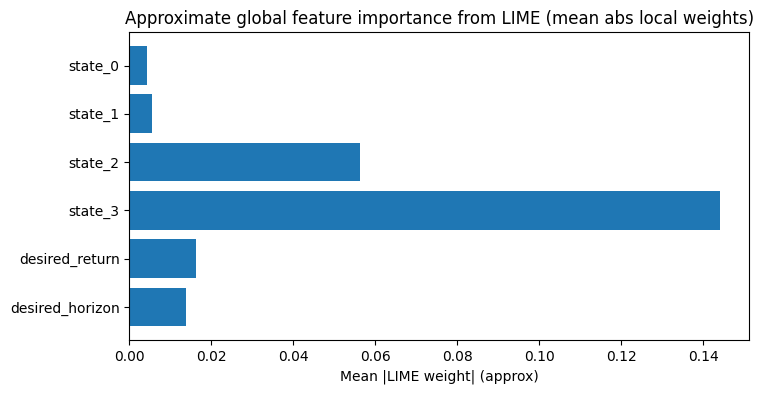

In [157]:

# --- 4) Explain multiple samples and save textual results ---
indices_to_explain = list(range(5))  # first 5 samples, for example
local_explanations = {}

for i in indices_to_explain:
    e = explainer.explain_instance(X[i], predict_fn, num_features=8, top_labels=1, num_samples=2000)
    pred = int(np.argmax(predict_fn(X[i].reshape(1, -1))[0]))
    local_explanations[i] = {
        "predicted_class": pred,
        "explanation_list": e.as_list(label=pred)  # list of (feature, weight)
    }

# print a summary
for i, info in local_explanations.items():
    print(f"\nSample {i} predicted class {info['predicted_class']}:")
    for feat, weight in info['explanation_list']:
        print(f"  {feat}: {weight:.4f}")

# --- 5) Simple "global" approximation: aggregate absolute weights across many local explanations ---
# This is not exact global importance, but gives intuition.
n_explain = 100  # explain 100 samples
indices = np.random.choice(X.shape[0], n_explain, replace=False)

# collect weights in a (n_explain, n_features) matrix for the predicted class each time
weights_matrix = np.zeros((n_explain, X.shape[1]))

for j, idx in enumerate(indices):
    e = explainer.explain_instance(X[idx], predict_fn, num_features=8, top_labels=1, num_samples=2000)
    pred = int(np.argmax(predict_fn(X[idx].reshape(1, -1))[0]))
    # e.as_list(label=pred) returns list of tuples ("feature_name <= x", weight)
    # convert into dict mapping feature_name -> weight
    feature_weight_dict = dict()
    for f, w in e.as_list(label=pred):
        # f == 'feature_name <= val' or 'feature_name > val' — extract the bare feature name
        bare_name = f.split(' ')[0]  # takes the first token (works if feature names are single tokens)
        feature_weight_dict[bare_name] = w
    
    # map into weights_matrix by feature order in feature_names
    for k, fname in enumerate(feature_names):
        weights_matrix[j, k] = feature_weight_dict.get(fname, 0.0)

# aggregate (mean absolute weight)
mean_abs_weights = np.mean(np.abs(weights_matrix), axis=0)

# plot approximate global importances
plt.figure(figsize=(8, 4))
plt.barh(feature_names, mean_abs_weights)
plt.xlabel("Mean |LIME weight| (approx)")
plt.title("Approximate global feature importance from LIME (mean abs local weights)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) Select 300 samples ---
n_samples = 100
indices = np.random.choice(X_combined.shape[0], n_samples, replace=False)

X_eval = X_combined[indices]
y_eval = y[indices]  # make sure y is numpy

# --- 2) Prediction function ---
def predict_classes(X):
    state = torch.tensor(X[:, :6], dtype=torch.float32) #For CartPole change to :4] for Acrobot use :6]
    command = torch.tensor(X[:, 6:], dtype=torch.float32)  #For CartPole change to :4] for Acrobot use :6]

    model.eval()
    with torch.no_grad():
        logits = model(state, command)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()
    return preds

y_pred = predict_classes(X_eval)

# --- 3) Metrics ---
acc = accuracy_score(y_eval, y_pred)
prec = precision_score(y_eval, y_pred, average="weighted")
rec = recall_score(y_eval, y_pred, average="weighted")
f1 = f1_score(y_eval, y_pred, average="weighted")

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("\nClassification report:\n")
print(classification_report(y_eval, y_pred))

# --- 4) Confusion matrix ---
cm = confusion_matrix(y_eval, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (100-sample subset)")
plt.show()
